<a href="https://colab.research.google.com/github/sb8919/Travelplus/blob/main/DL_model/BERT_%ED%83%9C%EA%B7%B8_%ED%8C%8C%EC%9D%BC2_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 패키지 다운로드
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.0 MB/s eta 0:00:00


In [ ]:
# 주요 패키지 불러오기
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import folium
import numpy as np
import random
import time
import datetime

In [ ]:
# GPU 확인
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


-------------

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라벨링 파일 데이터 프레임 형태로 가져오기
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/labeling_data_0528.xlsx')

In [ ]:
# 인스타그램 본문 내용에서 특수문자 공백으로 교환
df["sentences"] = df["sentences"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [ ]:
# 인스타그램 태그 내용에서 특수문자 공백으로 교환
df["tags"] = df["tags"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [ ]:
# 10개의 데이터 랜덤으로 출력
df.sample(n=10)

,Unnamed: 0,sentences,tags,place,label
1447,1447,,오늘여행_인제 인제자작나무숲 trip trippin instatr...,NaN,1.0
3152,3152,스타 셰프가 영혼을 갈아 넣어서 만든 카츠 카츠계의 패밀리 레스토랑 카인다카츠 ...,카인다카츠 주소경기 고양맛집 고양맛집추천 고양돈까스 고양돈까스맛집 ...,NaN,8.0
4074,4074,2572 1319 양은 안보고 놀이기구만 엄청 타고 옴 U0001fae0...,일상 세종시 증평 블랙스톤 벨포레 목장 놀이기구 루지 ...,NaN,3.0
687,687,장성군출렁다리 가보았어요 장성여행은 첨인데 아주 조용하게 걷기가 참 좋았던 길이에...,장성출렁다리 장성여행 장성가을여행 장성힐링여행,NaN,3.0
4599,4599,5 18 민주화 운동 43주년을 맞이해1980년대의 시대적 배경 5 18 민주화 운...,보훈역사여행 보훈교육 역사교육 역사 역사여행 랜선역사공부 5...,NaN,0.0
991,991,열심히 달려왔더니 어느덧 11월 중순,목포숙소 목퐁숙소추천 목포여행 목포필수코스 목포인기숙소 목포겨울...,NaN,2.0
3810,3810,NaN,광고 저는 산타미션 패러글라이딩 하늘에서산보기 패러글라이딩 패...,NaN,5.0
2951,2951,경북 청송 가볼만한곳 주산지겨울에서 봄으로 가는 풍경 조용하게 힐링하기 좋은 여행지,주산지 청송가볼만한곳,청송 주산지,1.0
6,6,봄입니다 마치 5월인듯 날씨가 봄날씨라 노곤노곤주무시는 우리 냥님들 잠이 늘었...,catclub_kaa abandoncatcafe catcafejipssau...,NaN,1.0
904,904,강원도 가을 단풍여행 명소 가볼 만한 곳인제 필례약수 단풍터널 어제 24일의 상황입니다,강원도래요 강원도여행 강원도가볼만한곳 단풍여행 단풍여행가볼만한곳 ...,필례약수,2.0


In [ ]:
# label 열의 값 float-> str
df['label'] = df['label'].astype(str)

In [ ]:
# label 분류 숫자로 변경
df.loc[(df['label'] == "0.0"), 'label'] = 0  #0.0 => 스팸 => 0
df.loc[(df['label'] == "1.0"), 'label'] = 1  #1.0 => 가볼만한곳 => 1
df.loc[(df['label'] == "2.0"), 'label'] = 2  #2.0 => 가족여행 => 2
df.loc[(df['label'] == "3.0"), 'label'] = 3  #3.0 => 관람 => 3
df.loc[(df['label'] == "4.0"), 'label'] = 4  #4.0 => 맛집 => 4
df.loc[(df['label'] == "5.0"), 'label'] = 5  #5.0 => 우정여행 => 5
df.loc[(df['label'] == "6.0"), 'label'] = 6  #6.0 => 전통 => 6
df.loc[(df['label'] == "7.0"), 'label'] = 7  #7.0 => 체험 => 7
df.loc[(df['label'] == "8.0"), 'label'] = 8  #8.0 => 카페 => 8
df.loc[(df['label'] == "9.0"), 'label'] = 9  #9.0 => 캠핑 => 9

<Axes: >

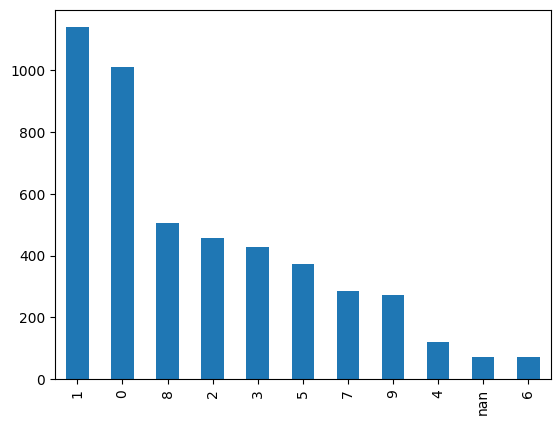

In [ ]:
# 데이터 정제하기
# label 값 분포 확인
df['label'].value_counts().plot(kind = 'bar')

In [ ]:
# 각 label 별 갯수 확인
df['label'].value_counts()

1      1139
0      1010
8       505
2       456
3       429
5       372
7       286
9       273
4       121
nan      73
6        73
Name: label, dtype: int64

In [ ]:
# Null 값 유무 확인 True <- Null 값 있음
print(df.isnull().values.any())

True


In [ ]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0       0
sentences        1
tags             0
place         2990
label            0
dtype: int64


In [ ]:
# Null 값 많은 place 열 제거
df = df.drop('place',axis=1)

In [ ]:
# 데이터 확인
df

,Unnamed: 0,sentences,tags,label
0,0,술이 달다 라고 하는걸 이걸보구 말하나봐요알쓰들도 무한대로 마실수 있는 연말을 ...,선릉 평상술집 술 술집 술안주 꿀주 꿀막걸리 막걸리 ...,8
1,1,,강남카페 강남대형카페도심 카즐_서울 카즐_강남 카즐_가로수길 카...,2
2,2,연타발 압구정 완전 대박인듯ㅜㅜ어느 하나 모자람없는 이 맛을 다양한 세계로 이끌어가...,도산공원맛집 연타발압구정본점 강남맛집 신사동맛집 압구정맛집 도산...,1
3,3,날 풀리면 가기 좋을 서울 테라스카페 모음집 뷰맛집으로 너무 핫한 서울 예쁜...,서울카페 서울카페추천 서울데이트 서울데이트코스 서울가볼만한곳 ...,9
4,4,가장 행복한 순간 배꼽집에서 고기 먹을 때 맛있게 구워서 한 점 한 점 먹으면 ...,배꼽집 강남맛집 삼성동맛집 삼성역맛집 봉은사역맛집 코엑스맛집 ...,8
...,...,...,...,...
4732,4732,올드카에 관심 있다면 규슈 자동차 박물관2023 03 08,사진 여행사진 일본 여행 유후인 일본여행 후쿠오카 규슈 ...,7
4733,4733,조선의 외교관 역관 부산박물관 특별기획전 전시관람하고 왔어요 아직 어린 아들...,부산박물관 특별기획전 전시관람 전시연출 박물관 포토스팟 역관...,7
4734,4734,어벤져스 엔드게임의 감동을 다시 한 번 피규어뮤지엄제주 2023 03 15,사진 여행사진 한국 제주 여행 풍경 한국여행 제주도 ...,7
4735,4735,사 한국박물관협회 회장 조한희 는 지난 5월 11일 목 부터 13일 토 까지 3일...,한국박물관협회 한박협 뮤지엄 박물관 미술관 제17회한국박물관국제...,0


In [ ]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0    0
sentences     1
tags          0
label         0
dtype: int64


In [ ]:
# Null값 제거
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
# 라벨 값별로 200개씩만 선택
label_counts = df['label'].value_counts()
selected_indices = []
for label in label_counts.index:
    label_indices = df[df['label'] == label].index.tolist()
    selected_indices += label_indices[:200]
selected_df = df.loc[selected_indices]

# 결과 확인
print(selected_df['label'].value_counts())


1      200
0      200
8      200
2      200
3      200
5      200
7      200
9      200
4      121
nan     73
6       73
Name: label, dtype: int64


In [ ]:
df = selected_df

1      200
0      200
8      200
2      200
3      200
5      200
7      200
9      200
4      121
nan     73
6       73
Name: label, dtype: int64


1867

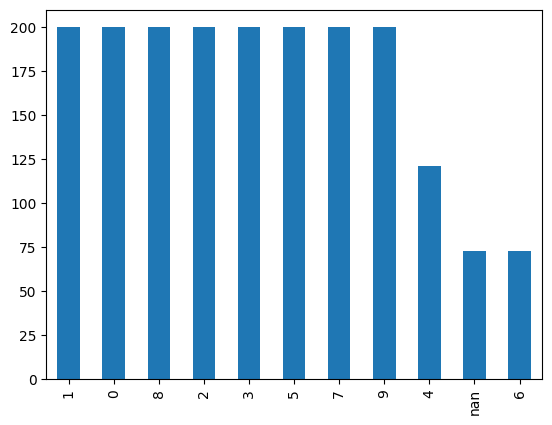

In [ ]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [ ]:
# label에서 nan 제거
df = df[df.label != 'nan']

1    200
0    200
8    200
2    200
3    200
5    200
7    200
9    200
4    121
6     73
Name: label, dtype: int64


1794

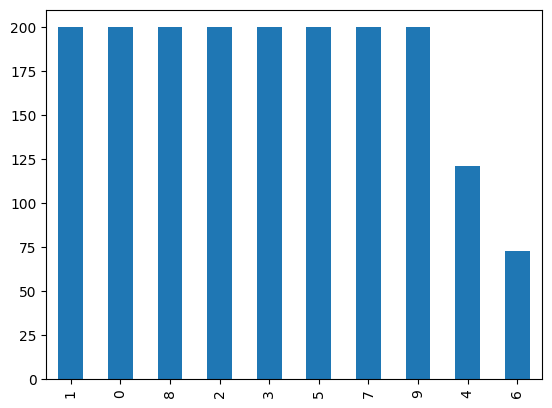

In [ ]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [ ]:
# Null값 제거 후 데이터 개수 확인
print(len(df))

1794


1    200
0    200
8    200
2    200
3    200
5    200
7    200
9    200
4    121
6     73
Name: label, dtype: int64


1794

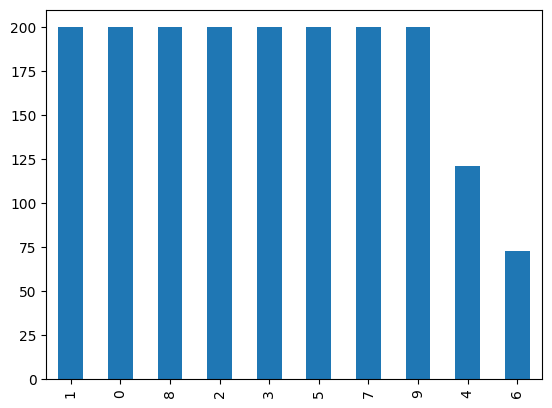

In [ ]:
# Null값 제거 후 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [ ]:
# label에서 nan 제거
df = df[df.label != 'nan']

1    200
0    200
8    200
2    200
3    200
5    200
7    200
9    200
4    121
6     73
Name: label, dtype: int64


1794

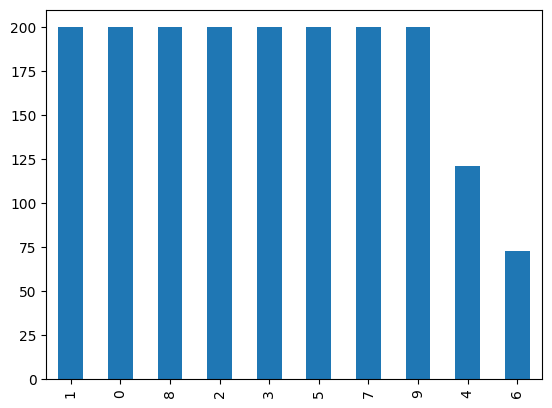

In [ ]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [ ]:
# data_list에 본문과 라벨링된 값 저장
data_list = []
for q, label in zip(df['tags'], df['label'])  :
    if q.strip() == '' or q.strip() == '.':
        print(q)
        continue
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(data_list[0])
print(data_list[500])
#print(data_list[1200])
# print(data_list[1800])
# print(data_list[2400])
# print(data_list[2800])
# print(data_list[-1])

[' 도산공원맛집   연타발압구정본점   강남맛집   신사동맛집   압구정맛집   도산대로맛집   압구정맛집연타발   강남가볼만한곳   압구정데이트   데이트맛집   고기집   한우   압구정맛집추천', '1']
[' 내가알던니가아냐   곱창구이   곱창동네   동해로컬맛집   강원도   동해   동해겨울여행   동해스타그램   여행스타그램   처음처럼스타그램   맛스타그램   술스타그램   여행에미치다', '8']


In [ ]:
#train & test 데이터로 나누기 train 80 test 20
from sklearn.model_selection import train_test_split
                                                         
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
# train data, test data 개수 확인
print(len(train))
print(len(test))

1435
359


In [ ]:
print(train)

      Unnamed: 0                                          sentences  \
322          322  온다 2417문의  010 7325 1300주소  인천광역시 강화군 길상면 동검길1...   
1848        1848  다락441 런치타임  12시부터 2시까지 다락441 지점에 방문하시면  모든 음료 ...   
2008        2008       최고의 배롱꽃     배롱꽃이 흐드러지게 피는 덕천서원    경남 산청군 ...   
539          539    _강원도 최초의 성당  풍수원성당100년 그리고도 10년 더  옛모습 그대로 간...   
332          332                                          총 10 5km    
...          ...                                                ...   
349          349                                         남해 풍경  적량항   
867          867                                          공사중이라니ㅠㅠ    
4096        4096                                           22 02 28   
2401        2401  비주얼부터 끝내주는 생 소갈비 남영동양문 신촌점 입니다 한번 맛보시면 못 끊습니다 ...   
595          595  거창 사과숲애 미술체험과 숲속 작은 연주회 이앤아이앙상블 미술을 전공한 안사장님이 ...   

                                                   tags label  
322    온다2417   인천숙소   인천풀빌라   인천가볼만한곳   인천숙소추천   인천...     3  
1848   청주카페   청주놀거리

------

문장별 전처리

In [ ]:
# CLS, SEP 붙이기 (문장의 시작, 끝)
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.tags]

In [ ]:
document_bert[:5]

['[CLS]  온다2417   인천숙소   인천풀빌라   인천가볼만한곳   인천숙소추천   인천펜션   인천가족숙소   인천커플여행   강화풀빌라   강화숙소   강화숙소추천   강화펜션   강화가족숙소   강화커플여행 [SEP]',
 '[CLS]  청주카페   청주놀거리   청주메이커스페이스   청주카페추천   청주핫플   청주육아   청주놀러갈만한곳   다락441   청주   성안길카페   북문로카페   충북맘   청주맘   대전맘   청주주말   아메리카노   런치타임 [SEP]',
 '[CLS]  덕천서원배롱나무   덕천서원   산청덕천서원   배롱나무명소   경남배롱나무   산청여름여행   산청가볼만한곳   서원여행   대한민국구석구석   kto9suk9suk   ig_korea   visitkorea   ig_asia   travelkorea   travelgram_korea   korealandscape   ig_today   ig_good   koreatravel   koreabyme [SEP]',
 '[CLS]  강원도   횡성   풍수원성당   횡성가을여행   횡성가볼만한곳   횡성성당   국내가을여행 [SEP]',
 '[CLS]  대부해솔길1코스   안산여행   안산가볼만한곳   안산커플여행   안산가족여행 [SEP]']

In [ ]:
#사전 학습된 BERT multilingual 모델 내 포함되어있는 토크나이저 활용
print('tokenizeing..')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)
tokenized_texts = [ tokenizer.tokenize(s) for s in document_bert]
print('tokenized_texts[0]:',tokenized_texts[0])

tokenizeing..


tokenized_texts[0]: ['[CLS]', '온', '##다', '##24', '##17', '인', '##천', '##숙', '##소', '인', '##천', '##풀', '##빌', '##라', '인', '##천', '##가', '##볼', '##만', '##한', '##곳', '인', '##천', '##숙', '##소', '##추', '##천', '인', '##천', '##펜', '##션', '인', '##천', '##가', '##족', '##숙', '##소', '인', '##천', '##커', '##플', '##여', '##행', '강', '##화', '##풀', '##빌', '##라', '강', '##화', '##숙', '##소', '강', '##화', '##숙', '##소', '##추', '##천', '강', '##화', '##펜', '##션', '강', '##화가', '##족', '##숙', '##소', '강', '##화', '##커', '##플', '##여', '##행', '[SEP]']


In [ ]:
#token들의 max length보다 크게 MAX_LEN을 설정한다. 설정한 MAX_LEN만큼 빈 공간을 0 이 채운다
print('padding')
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]
print('input_ids[0]:',input_ids[0])

padding
input_ids[0]: [   101   9582  11903  53398  34264   9640  38631 119063  22333   9640
  38631 119407 119002  17342   9640  38631  11287 101450  19105  11102
 118644   9640  38631 119063  22333 119274  38631   9640  38631 119393
  59095   9640  38631  11287  52560 119063  22333   9640  38631 106826
 119412  29935  25549   8853  18227 119407 119002  17342   8853  18227
 119063  22333   8853  18227 119063  22333 119274  38631   8853  18227
 119393  59095   8853 110817  52560 119063  22333   8853  18227 106826
 119412  29935  25549    102      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]


In [ ]:
#학습 속도를 높이기 위해 실 데이터가 있는 곳과 padding이 있는곳을 attention에게 알려줌

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print('attention_masks[0]:',attention_masks[0])

attention_masks[0]: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# input 과 mask가 뒤섞이지 않도록 random_state를 일정하게 고정.
# test set은 위에서 분리되었기에 , train 과 validation set만 분리
print('split train - val')
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, train['label'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42,test_size=0.1)

split train - val


In [ ]:
train_labels = train_labels.astype(int)

In [ ]:
validation_labels = validation_labels.astype(int)

In [ ]:
# numpy ndarray로 되어있는 input,lable,mask들을 torch tensor로 변환
print('convert data to tenser..')
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

convert data to tenser..


In [ ]:
#현재 쓰고있는 GPU의 VRAM에 맞게 배치사이즈 설정(크게 설정후 부족메시지가 뜨면 8의 배수중 작은것으로 줄여나가기)
print('set batch and data loader')
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

set batch and data loader


In [ ]:
#위의 train-val 셋 전처리와 동일
print('data split')
sentences = test['tags']
sentences = ["[CLS]"+str(sentence)+"[SEP]" for sentence in sentences]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

labels = labels.astype(int)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

data split


In [ ]:
import torch

print(torch.cuda.is_available())  # CUDA를 사용할 수 있는지 확인
print(torch.cuda.device_count())  # 사용 가능한 CUDA 디바이스 개수 확인

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))  # CUDA 디바이스 이름 출력


True
1
Tesla T4


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


## 분류를 위한 BERT 모델 생성
# transformers 의 BertForSequenceClassification 모듈 이용
print('making BERT model for classification')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=10)
#model.cuda()
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
making BERT model for classification


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# transformers에서 제공하는 옵티마이저 중 AdamW를 사용
# 총 훈련 스텝은 이터레이션 * 에폭 수로 설정
# 러닝 레잇 스케쥴러도 transformers에서 제공하는것을 사용

#옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 50

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

##학습
# accuracy 와 시간 표시함수 정의
# 정확도 계산 함수
print('train start')
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

train start


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 데이터로더에서 배치만큼 가져온 후 forward, backward pass를 수행
# gradient update는 명시적으로 하지 않고 위에서 로드한 optimizer를 활용
# 재현을 위해 랜덤시드 고정
# 모든 Epoch를 학습하면 학습이 종료

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("")


======== Epoch 1 / 50 ========
Training...

  Average training loss: 2.23
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.23
  Validation took: 0:00:01

======== Epoch 2 / 50 ========
Training...

  Average training loss: 1.91
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.38
  Validation took: 0:00:01

======== Epoch 3 / 50 ========
Training...

  Average training loss: 1.64
  Training epcoh took: 0:00:27

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:01

======== Epoch 4 / 50 ========
Training...

  Average training loss: 1.43
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.50
  Validation took: 0:00:01

======== Epoch 5 / 50 ========
Training...

  Average training loss: 1.28
  Training epcoh took: 0:00:27

Running Validation...
  Accuracy: 0.48
  Validation took: 0:00:01

======== Epoch 6 / 50 ========
Training...

  Average training loss: 1.09
  Training epcoh took: 0:00:27

Running Validation...
  Accu

In [ ]:
print('test start')
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))
print("test finished!")

test start

Accuracy: 0.51
Test took: 0:00:02
test finished!
